In [1]:
import numpy as np
import random

from npgpt.gpt import GPT
from npgpt.optim import Adam, SGD

import gc

In [2]:
def generate_addition_dataset(n_adds=700, n_digits=5):
    n_possible_digits = 10**n_digits
    xs = []
    ys = []
    for _ in range(n_adds):
        a = random.randint(0, n_possible_digits-1)
        b = random.randint(0, n_possible_digits-1) 
        c = a + b
        # encode the digits of a, b, c into strings
        astr = f'%0{n_digits}d' % a
        bstr = f'%0{n_digits}d' % b
        cstr = (f'%0{n_digits+1}d' % c) #[::-1]

        render = astr + bstr + cstr

        dix = [int(s) for s in render]

        x = np.array(dix[:-1])
        xs.append(x)

        y = np.array(dix[1:])
        y[:n_digits*2-1] = -1 
        ys.append(y)

    xs = np.array(xs)
    ys = np.array(ys)

    return xs, ys


In [3]:
N_DIGITS = 5
BLOCK_SIZE = 3*N_DIGITS
VOCAB_SIZE = 10

In [4]:
model = GPT(n_layers=1, n_heads=4, n_embd=64, vocab_size=VOCAB_SIZE, block_size=BLOCK_SIZE, pdrop=0)
optim = Adam(model.get_tensors(), learning_rate=5e-3, weight_decay=2.)

In [5]:

train_dataset = generate_addition_dataset(n_adds=300)
x, y = train_dataset

test_dataset = generate_addition_dataset(n_adds=1000)
x_test, y_test = test_dataset

In [6]:
train_losses = []
test_losses = []
epoch = 0

In [14]:
while epoch < 20_000:
    model.train()

    logits, loss = model(x, y)
    model.zero_grad()
    loss.backward()
    optim.step()
    gc.collect()  # hmm
    if not epoch%50:
        train_loss = loss.sum()
        train_losses.append(train_loss)
        model.eval()
        logits, test_loss = model(x_test, y_test)
        test_loss = test_loss.sum()
        test_losses.append(test_loss)
        if not epoch % 100:
                print(f"EPOCH {epoch}, Train loss: {train_loss}, Test loss: {test_loss}")

    epoch += 1

EPOCH 13600, Train loss: 0.024983860552310944, Test loss: 0.3669906556606293
EPOCH 13700, Train loss: 0.00281574041582644, Test loss: 0.1658521443605423
EPOCH 13800, Train loss: 0.31196820735931396, Test loss: 0.7006007432937622
EPOCH 13900, Train loss: 0.17208059132099152, Test loss: 0.4430210590362549
EPOCH 14000, Train loss: 0.01103015337139368, Test loss: 0.19591787457466125
EPOCH 14100, Train loss: 0.04247964173555374, Test loss: 0.2908872067928314
EPOCH 14200, Train loss: 0.0031591695733368397, Test loss: 0.13363951444625854
EPOCH 14300, Train loss: 0.027256231755018234, Test loss: 0.40926820039749146
EPOCH 14400, Train loss: 0.024005474522709846, Test loss: 0.29813599586486816
EPOCH 14500, Train loss: 0.03811364620923996, Test loss: 0.2588874399662018
EPOCH 14600, Train loss: 0.04575385898351669, Test loss: 0.30285730957984924
EPOCH 14700, Train loss: 0.045492276549339294, Test loss: 0.3049061596393585
EPOCH 14800, Train loss: 0.026882480829954147, Test loss: 0.26949816942214966

In [8]:
results = []
factors = np.array([[10**i for i in range(N_DIGITS+1)][::-1]]) 

xt = x_test
d1d2 = xt[:, :N_DIGITS*2]

d1d2d3 = model.generate(d1d2, N_DIGITS+1)

# isolate the last digit of the sampled sequence
d3 = d1d2d3[:, -(N_DIGITS+1):]
d3 = np.flip(d3, axis=1) # reverse the digits to their "normal" order
# decode the integers from individual digits
d1i = (d1d2[:,:N_DIGITS] * factors[:,1:]).sum(1)
d2i = (d1d2[:,N_DIGITS:N_DIGITS*2] * factors[:,1:]).sum(1)
d3i_pred = np.sum(d3 * factors, axis=1)
d3i_gt = d1i + d2i # manually calculate the ground truth
# evaluate the correctness of the results in this batch
correct = np.equal(d3i_pred, d3i_gt)
for i in range(len(xt)):
    results.append(int(correct[i]))
        # if not correct[i]:
        #     print(f"GPT claims that {d1i[i]} + {d2i[i]} = {d3i_pred[i]} but gt is {d3i_gt[i]}")

In [9]:
sum(results)

0

In [15]:
epoch

20000

In [16]:
N_DIGITS

5

In [ ]:
# loss.sum()

In [12]:
import matplotlib.pyplot as plt

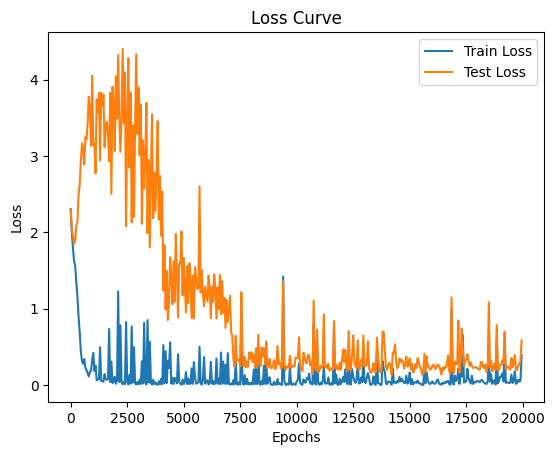

In [17]:
# Plot the loss curve
epochs = list(range(0, len(train_losses)*50, 50))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()